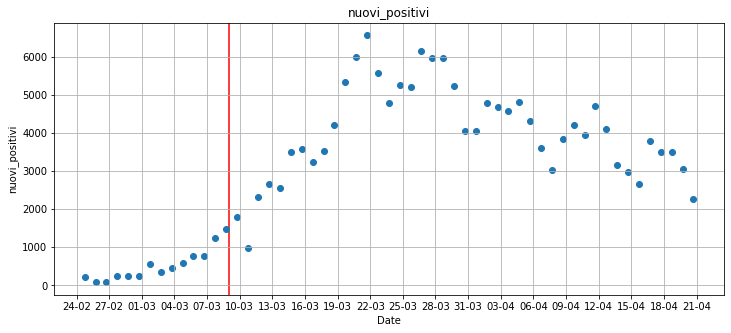

In [238]:
#INSTALL LIBRARIES

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")


data['diff_deceduti'] = data['deceduti'].diff()
data['diff_tamponi'] = data['tamponi'].diff()
#data['diff_terapia_intensiva'] = data['terapia_intensiva'].diff()
dates = data['data']
date_format = [pd.to_datetime(d) for d in dates]


variable = 'nuovi_positivi'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
ax.axvline(datetime(2020, 3, 9), c="red", zorder=0)
fig.savefig(variable + '.png')
plt.show()


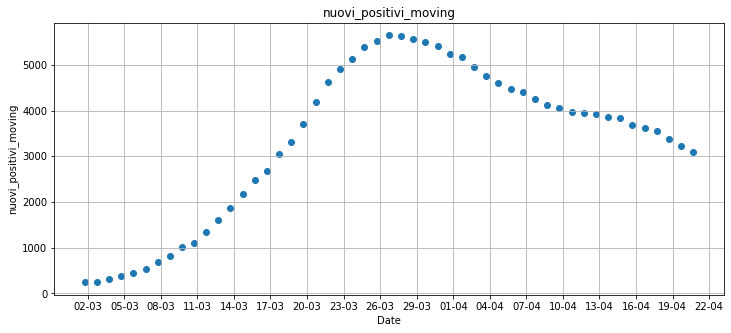

In [239]:
rolling_average_days = 7

data['nuovi_positivi_moving'] = data['nuovi_positivi'].rolling(window=rolling_average_days).mean()
#data['perc_positive'] = ((data['nuovi_positivi'])/(data['diff_tamponi'])*100).rolling(window=rolling_average_days).mean()

variable = 'nuovi_positivi_moving'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

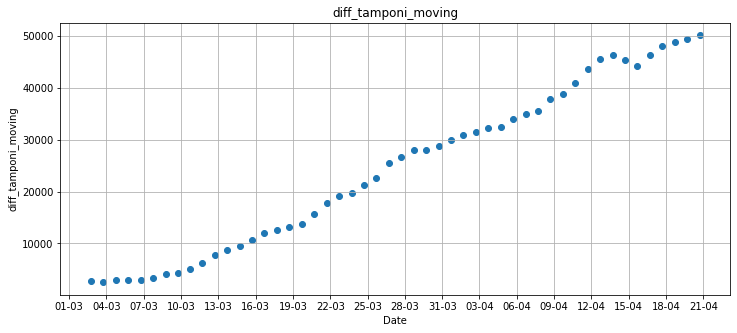

In [240]:

data['diff_tamponi_moving'] = data['tamponi'].diff().rolling(window=rolling_average_days).mean()

variable = 'diff_tamponi_moving'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

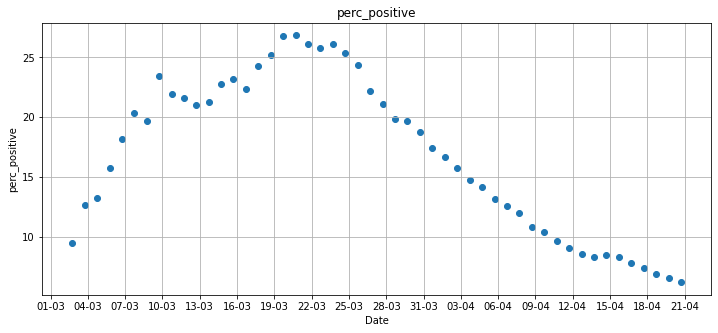

In [241]:
data['nuovi_positivi_moving'] = data['nuovi_positivi'].rolling(window=rolling_average_days).mean()
data['diff_tamponi_moving'] = data['tamponi'].diff().rolling(window=rolling_average_days).mean()
data['perc_positive'] = ((data['nuovi_positivi_moving'])/(data['diff_tamponi_moving'])*100)

variable = 'perc_positive'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

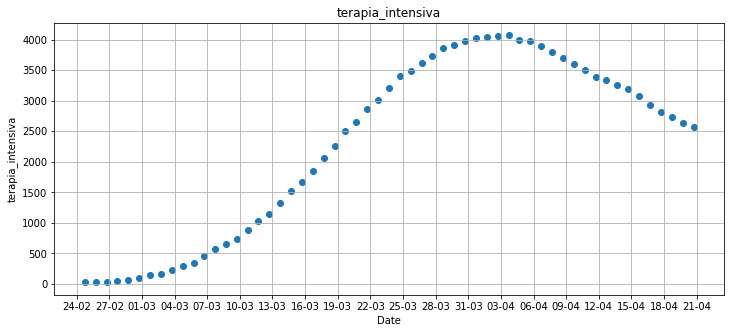

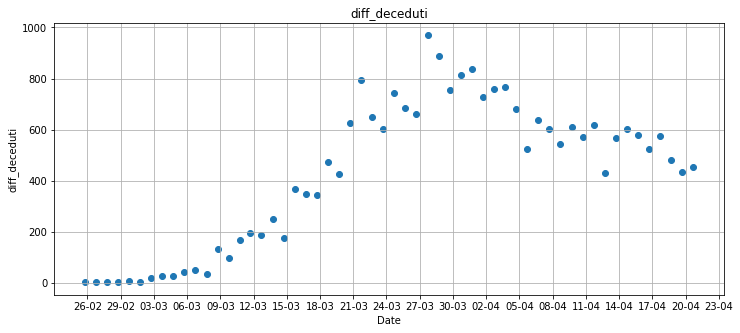

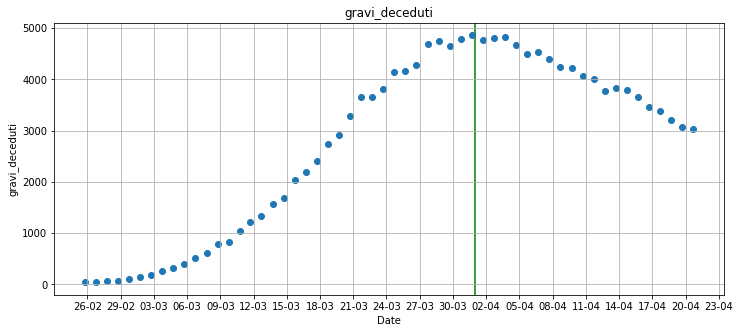

In [242]:
variable = 'terapia_intensiva'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
#ax.axvline(datetime(2020, 3, 20), c="red", zorder=0)
#ax.axvline(datetime(2020, 4, 1), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()

variable = 'diff_deceduti'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
#ax.axvline(datetime(2020, 3, 28), c="red", zorder=0)
#ax.axvline(datetime(2020, 4, 1), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()

data['gravi_deceduti'] =  data['diff_deceduti'] + data['terapia_intensiva']

variable = 'gravi_deceduti'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
ax.axvline(datetime(2020, 4, 1), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()



Zone 1 accounts for 84.95 percent of the total deaths

tamponi_giornalieri


/Users/andrea/venvs/covid_ita/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/andrea/venvs/covid_ita/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/andrea/venvs/covid_ita/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

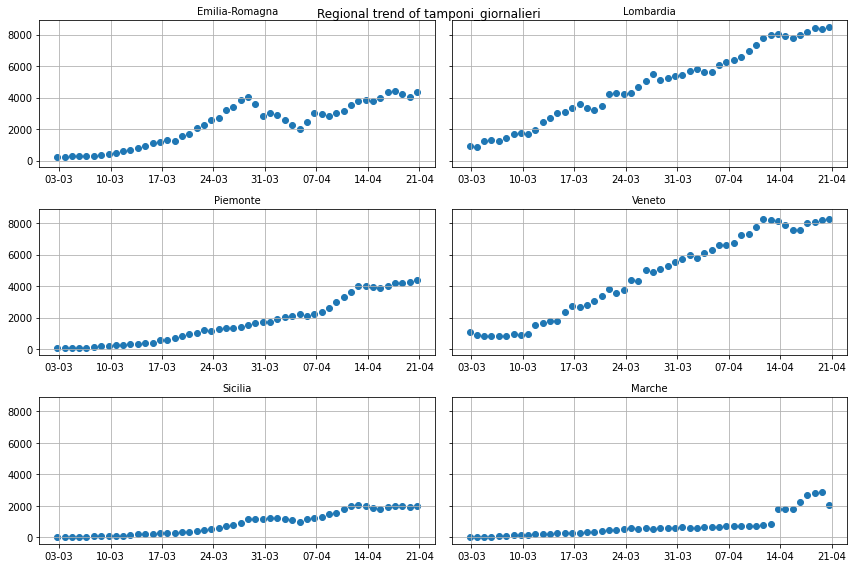

%_positive_tests


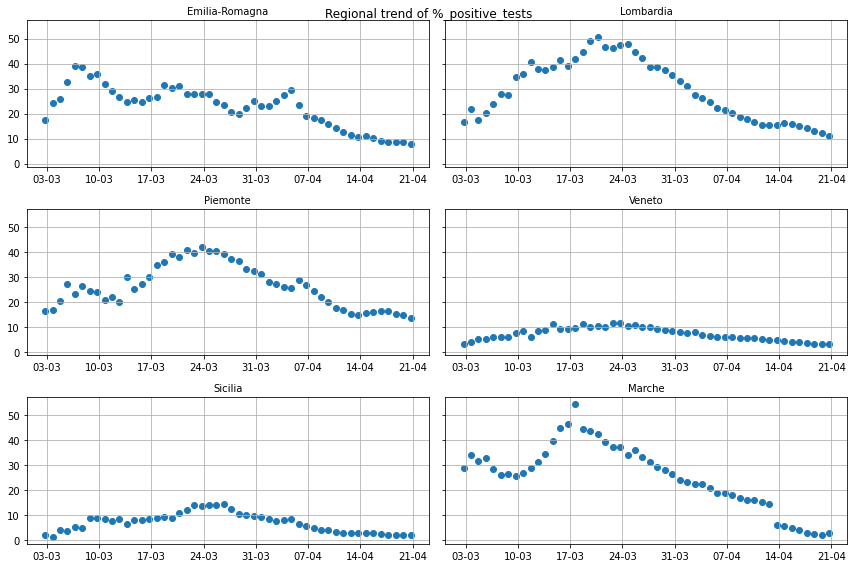

gravi_deceduti


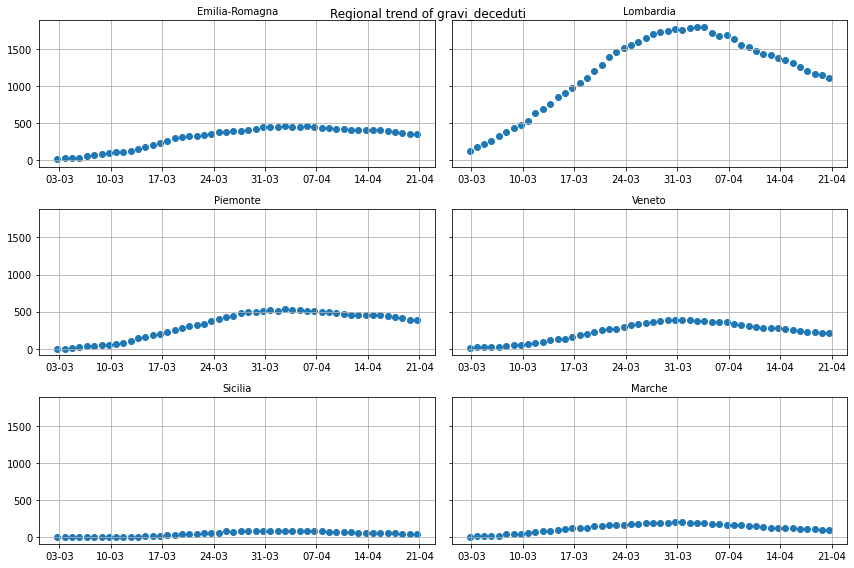

In [243]:
data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")

data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
#zone1_df = data[data.denominazione_regione.isin(['Piemonte','Emilia-Romagna','Veneto','Lombardia'])]
zone1_df = data[data.denominazione_regione.isin(['Piemonte','Emilia-Romagna','Veneto','Lombardia','Marche','Sicilia'])]
zone1_df['deceduti'].sum()
print ()
print("Zone 1 accounts for %s percent of the total deaths" % (round(zone1_df['deceduti'].sum() / data['deceduti'].sum() * 100,2)))
print ()

regions_dict = {'Emilia-Romagna': 8, 'Lombardia' : 3, 'Piemonte': 1,'Veneto': 5, 'Sicilia' : 19, "Marche" : 11}

rolling_average_days = 7
variable = '%_positive_tests'
regional_data_list = []
for region_name, region_code in regions_dict.items():
    is_region = data['codice_regione'] == region_code
    data_region = data[is_region]
    date = data_region['data']
    date_format = [pd.to_datetime(d) for d in date]
    data_region['nuovi_positivi'] = data_region['nuovi_positivi'].rolling(window=rolling_average_days).mean()
    data_region['diff_deceduti'] = data_region['deceduti'].diff().rolling(window=rolling_average_days).mean()
    data_region['tamponi_giornalieri'] = data_region['tamponi'].diff().rolling(window=rolling_average_days).mean()
    #data_region['diff_terapia_intensiva'] = data_region['terapia_intensiva'].diff()
    #data_region['diff_nuovi_positivi'] = data_region['nuovi_positivi'].diff().rolling(window=rolling_average_days).mean()
    data_region['%_positive_tests'] = ((data_region['nuovi_positivi'])/(data_region['tamponi_giornalieri'])*100)
    data_region['gravi_deceduti'] =  data_region['diff_deceduti'] + data_region['terapia_intensiva']
    regional_data_list.append(data_region)


list_of_variables = ['tamponi_giornalieri','%_positive_tests', 'gravi_deceduti']
#why piemonte bad in % e gravi deceduti -> tamponi giornalieri
#list_of_variables = ['%_positive_tests', 'gravi_deceduti']
for variable in list_of_variables:
    print(variable)
    fig, axs = plt.subplots(3, 2, sharey=True,figsize=(12, 8))
    fig.suptitle('Regional trend of ' + variable,fontsize = 'large')
    date_form = DateFormatter("%d-%m")
    counter = 0
    for ax in axs.flat:
        ax.scatter(date_format, regional_data_list[counter][variable])
        ax.set_title(regional_data_list[counter]['denominazione_regione'].iloc[0], fontsize='medium')
        #ax.axvline(datetime(2020, 3, 9), c="red", zorder=0)
        #ax.axvline(datetime(2020, 3, 23), c="green", zorder=0)
        #ax.set_ylim([0, 100])
        ax.xaxis.set_major_formatter(date_form)
        # Ensure a major tick for each week using (interval=1)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        # ax1.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
        ax.grid()
        counter +=1
    fig.tight_layout()
    fig.savefig('Regional trend of %s' + variable + '.png')
    plt.show()

Linear Regression Model Score: 0.9883718211658477


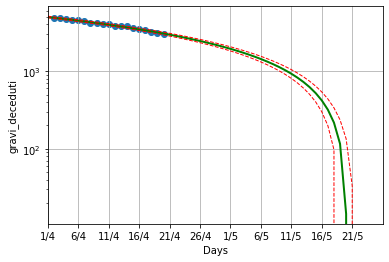

In [244]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
data['diff_deceduti'] = data['deceduti'].diff()
data['gravi_deceduti'] =  data['diff_deceduti'] + data['terapia_intensiva']
date = data['data']
date_format = [pd.to_datetime(d) for d in date]

import numpy as np
from sklearn import linear_model
# prepare the lists for the model
X = date_format
y = data['gravi_deceduti'].tolist()[1:]
# date format is not suitable for modeling, let's transform the date into incrementals number starting from April 1st
starting_date = 37  # April 1st is the 37th day of the series
day_numbers = []
for i in range(1, len(X)):
    day_numbers.append([i])
X = day_numbers
# # let's train our model only with data after the peak
X = X[starting_date:]
y = y[starting_date:]
# Instantiate Linear Regression
linear_regr = linear_model.LinearRegression()
# Train the model using the training sets
linear_regr.fit(X, y)
print ("Linear Regression Model Score: %s" % (linear_regr.score(X, y)))

# Predict future trend
from sklearn.metrics import max_error
import math
y_pred = linear_regr.predict(X)
error = max_error(y, y_pred)
error
X_test = []
future_days = 55

for i in range(starting_date, starting_date + future_days):
    X_test.append([i])
y_pred_linear = linear_regr.predict(X_test)
y_pred_max = []
y_pred_min = []
for i in range(0, len(y_pred_linear)):
    y_pred_max.append(y_pred_linear[i] + error)
    y_pred_min.append(y_pred_linear[i] - error)
    
# convert date 0 into datetime format
from datetime import datetime, timedelta
date_zero = datetime.strptime(data['data'][starting_date], '%Y-%m-%dT%H:%M:%S')
# date forecast
date_prev = []
x_ticks = []
step = 5
data_curr = date_zero
x_current = starting_date
n = int(future_days / step)
for i in range(0, n):
    date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
    x_ticks.append(x_current)
    data_curr = data_curr + timedelta(days=step)
    x_current = x_current + step

# plot results
plt.grid()
plt.scatter(X, y)
plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.xlim(starting_date, starting_date + future_days)
plt.xticks(x_ticks, date_prev)
plt.ylabel('gravi_deceduti')
plt.yscale("log")
plt.savefig("prediction.png")
plt.show()

In [245]:
import math

def n_to_date(n):
    return (date_zero + timedelta(days=n-starting_date)).strftime('%d/%m/%Y')
def build_line(x1,y1,x2,y2):
    m = float(y2 - y1)/(x2-x1)
    q = y1 - (m*x1)
    return [m,q]

data_zero = round(- linear_regr.intercept_ / linear_regr.coef_[0])
# n_to_date(data_zero)
# print ("N to date %s" % (n_to_date(data_zero)))

line_max = build_line(X_test[0][0], y_pred_max[0], X_test[1][0], y_pred_max[1])
data_zero_max = math.ceil(- line_max[1] / line_max[0])
data_zero_max = n_to_date(data_zero_max)

line_min = build_line(X_test[0][0], y_pred_min[0], X_test[1][0], y_pred_min[1])
data_zero_min = math.floor(- line_min[1] / line_min[0])
data_zero_min = n_to_date(data_zero_min)

print ("Zero intensive cares and deaths expected between %s and %s" % (data_zero_max, data_zero_min))

Zero intensive cares and deaths expected between 22/05/2020 and 18/05/2020
